# Bowel Segmentation using SegFormer

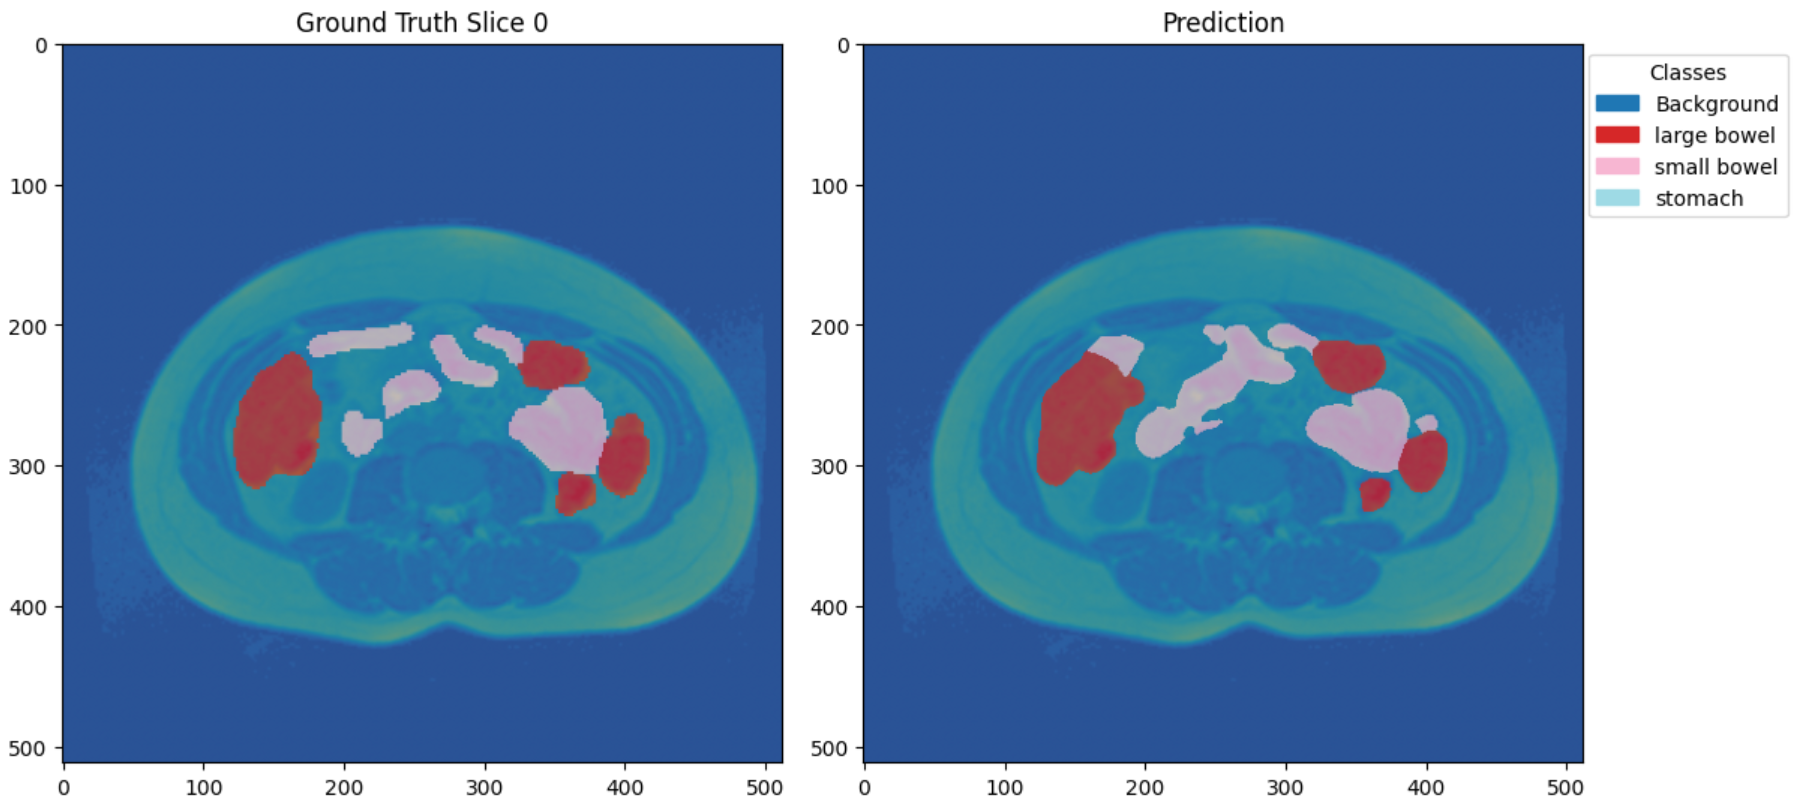

In [ ]:
# Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import numpy as np
import os
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from ipywidgets import interactive
import kagglehub
import pandas as pd
import cv2
from matplotlib.patches import Patch
from matplotlib.colors import BoundaryNorm
import SimpleITK as sitk
import ants
from torchvision.transforms.functional import to_pil_image
from sklearn.model_selection import train_test_split

## Load Dataset from kagglehub

In [ ]:
path = kagglehub.dataset_download("happyharrycn/uw-madison-gi-tract-image-segmentation-dataset")

### Dataset utitlities

In [ ]:
# hand coded color scheme for visualization (order RGB)
default_color_dict = {0 : (255/255., 102/255., 102/255.), #'ampulla_of_vater'
                      1 : (255/255., 178/255., 102/255.), #'large_bowel'
                      2 : (102/255., 255/255., 102/255.), #'pyloric_sphincter'
                      3 : (102/255., 255/255., 255/255.), #'small_bowel'
                      4 : (178/255., 102/255., 255/255.)} #'stomach'
# reference dict for mask type
mask_dict = {0 : 'ampulla of vater',
             1 : 'large bowel',
             2 : 'pyloric sphincter',
             3 : 'small bowel',
             4 : 'stomach'}

def process_image(img):
    gamma = 0.6
    img = img.astype(np.float32)
    img = img ** gamma
    if np.max(img) == 0:
        return np.zeros_like(img)
    else:
        img = img / np.max(img)
    return img

def rle_decode(mask_rle, shape, dtype=np.uint8):
    '''
    Helper function for run-length decoding
    ref.: https://www.kaggle.com/stainsby/fast-tested-rle
    Inputs:
        mask_rle: string formated RLE
        shape: (height,width) of array to return
        dtype: data type of array to return (default: uint8)
    Returns
        numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=dtype)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)



### Utitly Functions

In [ ]:
def verify_scan_path(scans_path, contours_path):
    """
    Verifies if there are valid (non-blank) scans present.
    Returns True if valid scans exist, False otherwise.
    """
    df_full = pd.read_csv(contours_path)
    cum_mean = 0
    file_count = 0

    for root, dirs, files in os.walk(scans_path):
        files = [f for f in files if f.endswith(('.png', '.jpg', '.jpeg', '.tif'))]

        if not files:
            continue

        for file in files:
            img = cv2.imread(os.path.join(root, file), 0)
            if img is None:
                continue

            img = process_image(img)

            if img.mean() < 0.1:
                continue

            slice_id = file[:10]
            df = df_full[df_full['SliceID'] == slice_id]

            if df.empty:
                continue

            if all(str(ep) in ['-1', '', 'nan'] for ep in df['EncodedPixels']):
                continue

            cum_mean += img.mean()
            file_count += 1

    # Use average mean per valid file instead of cumulative sum
    if file_count > 0:
        avg_mean = cum_mean / file_count
        # print(avg_mean)
        return bool(avg_mean > 0.1)
    return False

def calculate_class_weights(contours_path, class_dict):
    """
    Calculates class weights based on the frequency of each class in the dataset.
    Returns a dictionary with class IDs as keys and their corresponding weights as values."""

    # Read CSV once outside the loop
    df_full = pd.read_csv(contours_path)

    slice_ids = df_full['SliceID'].unique()

    for slice_id in slice_ids:
        df = df_full[df_full['SliceID'] == slice_id]
        if df.empty:
            continue
        mask_type_ids = df[df['EncodedPixels']!='-1']['MaskTypeID']
        for mask_type_id in mask_type_ids:
            if mask_type_id in class_dict:
                class_dict[mask_type_id] += 1
            else:
                class_dict[mask_type_id] = 1

    return class_dict

def get_augmentation_pipeline(is_train=True, img_size=512):
    """
    Creates augmentation pipeline for training or validation
    """
    if is_train:
        transform = A.Compose([
            A.Resize(img_size, img_size),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.05,
                scale_limit=0.1,
                rotate_limit=10,
                border_mode=0,
                p=0.5
            ),
            A.ElasticTransform(alpha=50, sigma=5, p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
        ])
    else:
        transform = A.Compose([
            A.Resize(img_size, img_size),
        ])

    return transform

## Train test split

In [ ]:
# base_path to the dataset
base_path = os.path.join(path , 'dataset')
samples = []
# load the path to each scan for the patients
for root, dirs, files in os.walk(base_path):
    if 'contours' in root:
       samples.append(os.path.dirname(root))
train_images, test_images = train_test_split(samples, test_size=0.1, random_state=101)

### Validate train image paths

In [ ]:
# only keep the valid samples
sample_sets = set(train_images)
temp_samples_set = sample_sets.copy()
loader = tqdm(total=len(temp_samples_set))
for sample in temp_samples_set:
    scans_path = os.path.join(sample, "scans" )
    contours_path = os.path.join(sample, "contours", "masks_rle.csv")
    if not verify_scan_path(scans_path, contours_path):
        sample_sets.remove(sample)
    loader.update(1)

# only keep the samples which have a mask
train_images_paths = []
verified_samples = list(sample_sets)
for path in verified_samples:

    tail = os.path.split(path)[1]
    parent = os.path.split(os.path.dirname(path))[1]
    scans_dir = os.path.join(parent, tail, 'scans')
    contours_dir = os.path.join(path, 'contours', 'masks_rle.csv')
    image_file_names_temp = [os.path.join(scans_dir, f) for f in os.listdir(os.path.join(path, 'scans')) if '.png' in f]
    image_file_names_temp_set = set(image_file_names_temp)
    for img_path in image_file_names_temp:
        slice_id = os.path.split(img_path)[1][:10]
        df = pd.read_csv(contours_dir)
        df = df[df['SliceID'] == slice_id]
        if df.empty or all(str(ep) in ['-1', '', 'nan'] for ep in df['EncodedPixels']):
            image_file_names_temp_set.remove(img_path)

    train_images_paths.extend(list(image_file_names_temp_set))



### Per class counts and class weights calculation for train-set

In [ ]:
loader = tqdm(total=len(sample_sets))
class_dict = {}
for sample in sample_sets:
    contours_path = os.path.join(sample, "contours", "masks_rle.csv")
    class_dict = calculate_class_weights(contours_path, class_dict)
    loader.update(1)
class_counts = dict(sorted(class_dict.items(), key=lambda x: x[0]))

# Remove Minority Classes
del class_counts[0]
del class_counts[2]

class_weights = np.array(list(class_counts.values())).mean()/np.array(list(class_counts.values()))

In [ ]:
class_weights

### Validate test image paths

In [ ]:
# only keep the test samples
sample_sets = set(test_images)
temp_samples_set = sample_sets.copy()
loader = tqdm(total=len(temp_samples_set))
for sample in temp_samples_set:
    scans_path = os.path.join(sample, "scans" )
    contours_path = os.path.join(sample, "contours", "masks_rle.csv")
    if not verify_scan_path(scans_path, contours_path):
        sample_sets.remove(sample)
    loader.update(1)

# only keep the samples which have a mask
test_image_paths = []
verified_samples = list(sample_sets)
for path in verified_samples:

    tail = os.path.split(path)[1]
    parent = os.path.split(os.path.dirname(path))[1]
    scans_dir = os.path.join(parent, tail, 'scans')
    contours_dir = os.path.join(path, 'contours', 'masks_rle.csv')
    image_file_names_temp = [os.path.join(scans_dir, f) for f in os.listdir(os.path.join(path, 'scans')) if '.png' in f]
    image_file_names_temp_set = set(image_file_names_temp)
    for img_path in image_file_names_temp:
        slice_id = os.path.split(img_path)[1][:10]
        df = pd.read_csv(contours_dir)
        df = df[df['SliceID'] == slice_id]
        if df.empty or all(str(ep) in ['-1', '', 'nan'] for ep in df['EncodedPixels']):
            image_file_names_temp_set.remove(img_path)

    test_image_paths.extend(list(image_file_names_temp_set))



### Dataset class

In [ ]:

# Custom Dataset Class for Semantic Segmentation
class BowelSegmentationDataset(Dataset):
    def __init__(self, root_dir, image_paths, processor, transform=None, num_classes=21):
        self.root_dir = root_dir
        self.image_paths = image_paths
        self.processor = processor
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_paths)

    def apply_denoise(self, raw_scans):
      """ Denoise MRI using ANTs Denoising """
      mri_image_vector = raw_scans
      raw_image_ants = ants.from_numpy(mri_image_vector)
      denoised_mri_ants = ants.denoise_image(raw_image_ants)
      denoised_mri = denoised_mri_ants.numpy()
      return denoised_mri

    def apply_bias_correction(self, denoised_mri):
      """ Apply N4 Bias Field Correction using SimpleITK """
      mri_data = sitk.GetImageFromArray(denoised_mri)
      transformed = sitk.RescaleIntensity(mri_data, 0, 255)
      msk = sitk.LiThreshold(transformed,0,1)
      shrink_factor = 3
      input_image = sitk.Shrink(mri_data, [shrink_factor]*mri_data.GetDimension())
      msk_image = sitk.Shrink(msk, [shrink_factor]*msk.GetDimension())
      bfc = sitk.N4BiasFieldCorrectionImageFilter()
      corrected = bfc.Execute(mri_data, msk)
      bias_field_corrected = bfc.GetLogBiasFieldAsImage(mri_data)
      full_resolution_corrected = mri_data/sitk.Exp(bias_field_corrected)
      mri_corrected = sitk.GetArrayFromImage(full_resolution_corrected)
      return mri_corrected

    def load_depth_images(self,path1, path2):
      """ Load and process depth images """
      depth_img1 = cv2.imread(path1, 0)
      depth_img2 = cv2.imread(path2, 0)
      depth_img1 = process_image(depth_img1)
      depth_img2 = process_image(depth_img2)
      return depth_img1, depth_img2

    def preprocess_image(self, img, idx):
      """ Preprocess image with denoising and bias correction using neighboring slices """
      if idx==0:
        depth_img_path1 = os.path.join(self.root_dir, self.image_paths[idx+1])
        depth_img_path2 = os.path.join(self.root_dir, self.image_paths[idx+2])
        depth_img1, depth_img2 = self.load_depth_images(depth_img_path1, depth_img_path2)
        raw_scans = np.stack([img.astype('float32'),depth_img1.astype('float32'), depth_img2.astype('float32')], axis=0)
        denoised_mri = self.apply_denoise(raw_scans)
        mri_corrected = self.apply_bias_correction(denoised_mri)
        img = mri_corrected[0,:,:]
      elif idx==len(self.image_paths)-1:
        depth_img_path1 = os.path.join(self.root_dir, self.image_paths[idx-1])
        depth_img_path2 = os.path.join(self.root_dir, self.image_paths[idx-2])
        depth_img1, depth_img2 = self.load_depth_images(depth_img_path1, depth_img_path2)
        raw_scans = np.stack([depth_img1.astype('float32'), depth_img2.astype('float32'),img.astype('float32')], axis=0)
        denoised_mri = self.apply_denoise(raw_scans)
        mri_corrected = self.apply_bias_correction(denoised_mri)
        img = mri_corrected[2,:,:]
      else:
        depth_img_path1 = os.path.join(self.root_dir, self.image_paths[idx-1])
        depth_img_path2 = os.path.join(self.root_dir, self.image_paths[idx+1])
        depth_img1, depth_img2 = self.load_depth_images(depth_img_path1, depth_img_path2)
        raw_scans = np.stack([depth_img1.astype('float32'), img.astype('float32'), depth_img2.astype('float32')], axis=0)
        denoised_mri = self.apply_denoise( raw_scans)
        mri_corrected = self.apply_bias_correction(denoised_mri)
        img = mri_corrected[1,:,:]
      return img

    def __getitem__(self, idx):
      """ Get item method to load image and corresponding mask """
      # Removing 0 and 2
      KEEP_CLASSES = [1, 3, 4]
      CLASS_REMAP = {old: new for new, old in enumerate(sorted(KEEP_CLASSES))}
      REMOVE_CLASSES = [0, 2]

      img_path = self.image_paths[idx]
      img_path = os.path.join(self.root_dir, img_path)

      slice_id = os.path.split(self.image_paths[idx])[1][:10]
      contour_mask_path = os.path.split(os.path.split(self.image_paths[idx])[0])[0]
      contour_mask_path = os.path.join(contour_mask_path, 'contours', 'masks_rle.csv')
      contours_path = os.path.join(self.root_dir, contour_mask_path)
      # Load image
      img = cv2.imread(img_path, 0)
      img = process_image(img)

      img = self.preprocess_image(img, idx)

      # Get mask
      df = pd.read_csv(contours_path)
      df = df[df['SliceID'] == slice_id]
      df = df[~df['MaskTypeID'].isin(REMOVE_CLASSES)]
      h, w = img.shape
      mask = np.zeros((h, w), dtype=np.int64)
      for _, row in df.iterrows():
          mask_rle = row['EncodedPixels']
          mask_type = row['MaskTypeID']

          if str(mask_rle) not in ['-1', '', 'nan', 'None']:
              decoded = rle_decode(mask_rle, shape=(h, w), dtype=np.float32)
              mask[decoded == 1] = CLASS_REMAP[mask_type] + 1

      if self.transform:
          augmented = self.transform(image=img, mask=mask)
          img = augmented['image']
          mask = augmented['mask']
      img = np.expand_dims(img, axis=0)
      img = np.repeat(img, 3, axis=0)  # (3, 266, 266)
      img = np.transpose(img, (1, 2, 0))
      # plt.imshow(img)
      encoded = self.processor(images=img, segmentation_maps=mask, return_tensors="pt")

      # Remove batch dimension
      for k, v in encoded.items():
          encoded[k] = v.squeeze(0)
      # dict with 'pixel_values' and 'labels'
      return encoded



## Custom Loss Function

In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, weights=None):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weights)

    def dice_loss(self, pred, target, num_classes=4):
        """Computes the Dice loss, excluding the background class."""
        pred_soft = torch.softmax(pred, dim=1)
        target_oh = F.one_hot(target, num_classes).permute(0, 3, 1, 2).float()

        intersection = (pred_soft * target_oh).sum(dim=(2, 3))
        union = pred_soft.sum(dim=(2, 3)) + target_oh.sum(dim=(2, 3))

        dice = (2 * intersection + 1e-6) / (union + 1e-6)
        return 1 - dice[:, 1:].mean()  # Exclude background

    def forward(self, pred, target):
        return self.ce(pred, target) + self.dice_loss(pred, target)

## Model Trainer

In [ ]:
# Training Function
class SegFormerTrainer:
    def __init__(self, model, train_loader, val_loader, device, num_classes, optimizer=None, scheduler=None, start_epoch=0, best_iou=0.0):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        self.start_epoch=start_epoch
        self.best_iou = best_iou

        # weights = torch.FloatTensor([0.81251513, 1.01920595, 1.26887818])
        weights = torch.FloatTensor([0.81251513, 2.0, 1.26887818])
        weights = torch.cat([torch.tensor([0.3]), weights]).to(device)
        print("class weights applied: ", weights)
        self.criterion = CombinedLoss(weights=weights)

        # Optimizer
        if optimizer is None:
          self.optimizer = torch.optim.AdamW([
      {"params": model.segformer.encoder.parameters(), "lr": 1e-5},
      {"params": model.decode_head.parameters(), "lr": 1e-4},
  ], weight_decay=0.01)
        else:
          self.optimizer = optimizer

        # Learning rate scheduler
        if scheduler is None:
          self.scheduler = CosineAnnealingLR(
              self.optimizer,
              T_max=len(train_loader) * 200,
              eta_min=1e-6
          )
        else:
          self.scheduler = scheduler

        self.train_losses = []
        self.val_losses = []
        self.val_ious = []

    def compute_iou(self, preds, labels):
        """Compute IoU metric for semantic segmentation"""
        ious = []
        preds = preds.view(-1)
        labels = labels.view(-1)

        for cls in range(self.num_classes):
            pred_cls = preds == cls
            label_cls = labels == cls

            intersection = (pred_cls & label_cls).float().sum()
            union = (pred_cls | label_cls).float().sum()

            if union == 0:
                ious.append(float('nan'))
            else:
                ious.append((intersection / union).item())

        return np.nanmean(ious)

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        progress_bar = tqdm(self.train_loader, desc="Training")

        for batch_idx, batch in enumerate(progress_bar):
            inputs = {k: v.to(self.device) for k, v in batch.items() if k != 'labels'}
            masks = batch['labels'].to(self.device)
            # Forward pass
            outputs = self.model(**inputs)
            logits = outputs.logits

            # Upsample logits to match mask size
            upsampled_logits = nn.functional.interpolate(
                logits,
                size=masks.shape[-2:],
                mode="bilinear",
                align_corners=False
            )

            # Calculate loss
            loss = self.criterion(upsampled_logits, masks)

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.scheduler.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

        return total_loss / len(self.train_loader)

    def validate(self):
        self.model.eval()
        total_loss = 0
        total_iou = 0

        with torch.no_grad():
            progress_bar = tqdm(self.val_loader, desc="Validation")
            for batch_idx, batch in enumerate(progress_bar):
              inputs = {k: v.to(self.device) for k, v in batch.items() if k != 'labels'}
              masks = batch['labels'].to(self.device)
              outputs = self.model(**inputs)
              logits = outputs.logits

              upsampled_logits = nn.functional.interpolate(
                  logits,
                  size=masks.shape[-2:],
                  mode="bilinear",
                  align_corners=False
              )

              loss = self.criterion(upsampled_logits, masks)
              total_loss += loss.item()

              # Compute IoU
              preds = upsampled_logits.argmax(dim=1)
              iou = self.compute_iou(preds, masks)
              total_iou += iou

              progress_bar.set_postfix({'loss': loss.item(), 'IoU': iou})

        avg_loss = total_loss / len(self.val_loader)
        avg_iou = total_iou / len(self.val_loader)

        return avg_loss, avg_iou

    def train(self, num_epochs):
        best_iou = self.best_iou
        patience= 10
        patience_counter=0
        best_state=None
        for epoch in range(self.start_epoch, num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")

            # Training
            train_loss = self.train_epoch()
            self.train_losses.append(train_loss)

            # Validation
            val_loss, val_iou = self.validate()
            self.val_losses.append(val_loss)
            self.val_ious.append(val_iou)

            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Best IoU: {best_iou:.4f}")

            # Save best model
            if val_iou > best_iou:
                best_iou = val_iou
                patience_counter = 0
                best_state = self.model.state_dict()
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': best_state,
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    "scheduler": self.scheduler.state_dict(),
                    'best_iou': best_iou,
                }, "/content/drive/MyDrive/bowseg_t3.pth")
                print(f"Saved best model with IoU: {best_iou:.4f}")
            else:
              patience_counter+=1
              if patience_counter>=patience:
                print(f"Convered at Epoch: {epoch},IoU: {best_iou:.4f}")
                if best_state is not None:
                  self.model.load_state_dict(best_state)
                break

## Model and Data Init

In [ ]:

BATCH_SIZE = 32
NUM_EPOCHS = 30
NUM_CLASSES = 4  # Change based on your dataset
IMG_SIZE = 512
MODEL_NAME = "nvidia/segformer-b0-finetuned-ade-512-512"  # You can use b0-b5

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize processor and model
processor = SegformerImageProcessor.from_pretrained(MODEL_NAME, do_rescale=False)
model = SegformerForSemanticSegmentation.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True
)
model = model.to(device)



# Create datasets
train_dataset = BowelSegmentationDataset(
    root_dir= base_path,
    image_paths = train_images_paths,
    processor=processor,
    transform=get_augmentation_pipeline(is_train=True, img_size=IMG_SIZE),
    num_classes=NUM_CLASSES
)

val_dataset = BowelSegmentationDataset(
    root_dir= base_path,
    image_paths = test_image_paths,
    processor=processor,
    transform=get_augmentation_pipeline(is_train=False, img_size=IMG_SIZE),
    num_classes=NUM_CLASSES
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


### Lengths

In [ ]:
len(train_loader), len(train_dataset), len(val_loader), len(val_dataset)

#### Train input and mask


In [ ]:

plt.subplot(121)
plt.imshow(to_pil_image(train_dataset[0]['pixel_values']))
plt.subplot(122)
plt.imshow(train_dataset[0]['labels'])

## Model Utilities

In [ ]:
def load_checkpoint(model, train_loader):
    """Load model, optimizer, and scheduler states from checkpoint"""
    states = torch.load("/content/drive/MyDrive/bowseg_t3.pth",
                        map_location="cuda", weights_only=False )

    device = torch.device("cuda")

    # Load model weights
    model.load_state_dict(states["model_state_dict"])

    # Create optimizer AFTER model is on CUDA
    optimizer = torch.optim.AdamW([
        {"params": model.segformer.encoder.parameters(), "lr": 1e-5},
        {"params": model.decode_head.parameters(), "lr": 1e-4},
    ], weight_decay=0.01)
    # Load optimizer state
    optimizer.load_state_dict(states["optimizer_state_dict"])
    for state in optimizer.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.to(device)

    # Create scheduler
    scheduler = CosineAnnealingLR(
                optimizer,
                T_max=len(train_loader) * 200,  # 60 epochs
                eta_min=1e-6
            )

    # Load scheduler state
    scheduler.load_state_dict(states["scheduler"])
    start_epoch = states["epoch"] + 1
    best_iou = states["best_iou"]
    return model, optimizer, scheduler, start_epoch, best_iou


## Finetuning

In [ ]:
model

# Finetuning Start

In [ ]:
# Initialize trainer
trainer = SegFormerTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_classes=NUM_CLASSES
)

# Train model
trainer.train(num_epochs=200)

print("Training completed!")

### Load Best model


In [ ]:
model, optimizer, scheduler, start_epoch, best_iou = load_checkpoint(model, train_loader)

#### Resume training from epoch 4

In [ ]:
# Initialize trainer
trainer = SegFormerTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_classes=NUM_CLASSES,
    optimizer=optimizer,
    scheduler=scheduler,
    start_epoch=start_epoch,
    best_iou=best_iou
)

# Train model
trainer.train(num_epochs=200)

print("Training completed!")

### Resume training from epoch 7

In [ ]:
model, optimizer, scheduler, start_epoch, best_iou = load_checkpoint(model, train_loader)
trainer = SegFormerTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_classes=NUM_CLASSES,
    optimizer=optimizer,
    scheduler=scheduler,
    start_epoch=start_epoch,
    best_iou=best_iou
)

# Train model
trainer.train(num_epochs=200)

print("Training completed!")

### Resume training from epoch 15

In [ ]:
model, optimizer, scheduler, start_epoch, best_iou = load_checkpoint(model, train_loader)
trainer = SegFormerTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_classes=NUM_CLASSES,
    optimizer=optimizer,
    scheduler=scheduler,
    start_epoch=start_epoch,
    best_iou=best_iou
)

# Train model
trainer.train(num_epochs=200)

print("Training completed!")

### Resume training from epoch 23, with increased class weight for class 2

In [ ]:
model, optimizer, scheduler, start_epoch, best_iou = load_checkpoint(model, train_loader)
trainer = SegFormerTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_classes=NUM_CLASSES,
    optimizer=optimizer,
    scheduler=scheduler,
    start_epoch=start_epoch,
    best_iou=best_iou
)

# Train model
trainer.train(num_epochs=200)

print("Training completed!")

### Resume training from epoch 26

In [ ]:
model, optimizer, scheduler, start_epoch, best_iou = load_checkpoint(model, train_loader)
trainer = SegFormerTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_classes=NUM_CLASSES,
    optimizer=optimizer,
    scheduler=scheduler,
    start_epoch=start_epoch,
    best_iou=best_iou
)

# Train model
trainer.train(num_epochs=200)

print("Training completed!")

### Resume training from epoch 40

In [ ]:
model, optimizer, scheduler, start_epoch, best_iou = load_checkpoint(model, train_loader)
trainer = SegFormerTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_classes=NUM_CLASSES,
    optimizer=optimizer,
    scheduler=scheduler,
    start_epoch=start_epoch,
    best_iou=best_iou
)

# Train model
trainer.train(num_epochs=200)

print("Training completed!")

### Resume training from epoch 52

In [ ]:
model, optimizer, scheduler, start_epoch, best_iou = load_checkpoint(model, train_loader)
trainer = SegFormerTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_classes=NUM_CLASSES,
    optimizer=optimizer,
    scheduler=scheduler,
    start_epoch=start_epoch,
    best_iou=best_iou
)

# Train model
trainer.train(num_epochs=200)

print("Training completed!")

## Testing

In [ ]:
states = torch.load("/content/drive/MyDrive/bowseg_t3.pth",
                    map_location="cpu", weights_only=False )

device = torch.device("cpu")

# 2. Load model weights
model.load_state_dict(states["model_state_dict"])

### Test Utilities

In [ ]:
def predict(model, loader, device, description):
  model.eval()
  with torch.no_grad():
      progress_bar = tqdm(loader, desc=description)
      for batch_idx, batch in enumerate(progress_bar):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        masks = batch['labels'].to(device)
        outputs = model(**inputs)
        logits = outputs.logits

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )
        preds = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()
        progress_bar.reset()

  return inputs, masks, preds

def visualize(test_case, desc, slice_id=None):
  path = os.path.join(base_path,test_case)
  tail = os.path.split(path)[1]
  parent = os.path.split(os.path.dirname(path))[1]
  scans_dir = os.path.join(parent, tail, 'scans')
  image_file_names = [os.path.join(scans_dir, f) for f in sorted(os.listdir(os.path.join(path, 'scans'))) if '.png' in f]

  # # Create datasets
  patient_dataset = BowelSegmentationDataset(
      root_dir= base_path,
      image_paths = image_file_names,
      processor=processor,
      transform=get_augmentation_pipeline(is_train=False, img_size=IMG_SIZE),
      num_classes=NUM_CLASSES
  )

  # Create data loaders
  patient_loader = DataLoader(
      patient_dataset,
      batch_size=len(image_file_names),
      shuffle=False,
      num_workers=2,
      pin_memory=True
  )

  inputs, masks, preds = predict(model, patient_loader, torch.device("cpu"), desc)
  input = inputs['pixel_values'].squeeze().cpu().permute(0 ,2, 3, 1).numpy()
  input = (input - input.min()) / (input.max() - input.min())

  def visualize_predictions(slice_id):
    class_names = ["Background", "large bowel", "small bowel", "stomach"]
    num_classes = len(class_names)
    i = slice_id
    cmap = plt.get_cmap("tab20", num_classes)
    bounds = np.arange(num_classes + 1)
    norm = BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(12, 6))

    img = cv2.cvtColor(input[i], cv2.COLOR_BGR2GRAY)

    # Ground Truth
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="viridis")
    plt.imshow(masks[i], cmap=cmap, norm=norm, alpha=0.7)
    plt.title(f"Ground Truth Slice {i}")

    # Prediction
    plt.subplot(1, 2, 2)
    plt.imshow(img, cmap="viridis")
    plt.imshow(preds[i], cmap=cmap, norm=norm, alpha=0.7)
    plt.title("Prediction")

    # Legend
    legend_patches = [
        Patch(color=cmap(j), label=class_names[j])
        for j in range(num_classes)
    ]

    plt.legend(
        handles=legend_patches,
        loc="upper right",
        bbox_to_anchor=(1.30, 1),
        title="Classes"
    )

    plt.tight_layout()
    plt.show()

  if slice_id:
    visualize_predictions(slice_id=slice_id)
  else:
    iplot = interactive(visualize_predictions, slice_id=(0, len(image_file_names)-1))
    return iplot


In [ ]:
def visualize(test_case, desc):
  path = os.path.join(base_path,test_case)
  tail = os.path.split(path)[1]
  parent = os.path.split(os.path.dirname(path))[1]
  scans_dir = os.path.join(parent, tail, 'scans')
  image_file_names = [os.path.join(scans_dir, f) for f in os.listdir(os.path.join(path, 'scans')) if '.png' in f]
  print(sorted(os.listdir(os.path.join(path, 'scans'))))


### Test-cases from test-set

In [ ]:
test_cases = [os.path.join("case43", "case43_day20"), os.path.join("case136","case136_day29"), os.path.join("case121","case121_day0"), ]

In [ ]:
visualize(test_cases[0], "Test Patient 1", 90)

In [ ]:
visualize(test_cases[1], "Test Patient 2", 83)

In [ ]:
visualize(test_cases[2], "Test Patient 3", 87)

## Evaluation

#### Metrics used IoU: for mean IoU and class-wise IoU

In [ ]:
num_classes = 4
class_intersection = torch.zeros(num_classes)
class_union = torch.zeros(num_classes)

model.eval()
with torch.no_grad():
    progress_bar = tqdm(val_loader, desc="Per-class IoU")
    for batch in progress_bar:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        masks = batch['labels'].to(device)

        outputs = model(**inputs)
        logits = outputs.logits

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        preds = upsampled_logits.argmax(dim=1)

        for c in range(num_classes):
            pred_c = (preds == c)
            target_c = (masks == c)
            class_intersection[c] += (pred_c & target_c).sum().cpu()
            class_union[c] += (pred_c | target_c).sum().cpu()

print("\n" + "="*30)
print("Per-class IoU Results:")
print("="*30)
for c in range(num_classes):
    iou = (class_intersection[c] + 1e-6) / (class_union[c] + 1e-6)
    print(f"Class {c}: IoU = {iou:.4f}")

mean_iou = sum((class_intersection[c] + 1e-6) / (class_union[c] + 1e-6)
                for c in range(num_classes)) / num_classes
print(f"\nMean IoU: {mean_iou:.4f}")
print("="*30)